In [15]:
#Libraries
import random as rd
import math
import numpy as np
import operator
import copy
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from types import *
Logs = True

In [16]:
#Data obtention
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = np.array([image.reshape((28,28)) for image in X])
y = np.array(y)

In [33]:
#Function tools
def feature_extractor(image, box_size = 6, stride = 6, ignore_borders = 2):
    """Receives a numpy matrix as image, returns mean and standard deviation for every squared box"""
    features = []
    image = image[ ignore_borders : -ignore_borders , ignore_borders : -ignore_borders]
    horizontal_jumps = int((image.shape[0] - box_size) / stride)
    vertical_jumps = int((image.shape[1] - box_size) / stride)
    for i in range(horizontal_jumps):
        for j in range(vertical_jumps):
            vertical_start = j * stride
            horizontal_start = i * stride
            box = image[ vertical_start : vertical_start + box_size , horizontal_start : horizontal_start + box_size]
            features.append(np.mean(box))
            features.append(np.std(box))
    return np.array(features)

def colored_plot(x,y, values, title = "", colormap = "cool"):
    """points are x,y pairs, values are used for colors"""
    max_value = max(values)
    min_value = min(values)
    colors = [(value - min_value) / (max_value - min_value) for value in values]
    plt.scatter(x, y, c = colors, cmap = colormap)
    plt.title(title)
    plt.grid()
    plt.show()
    

def safe_divide(a, b):
    """This function provides a 'safe' division for two numbers. If the denominator b
    is 0, the function will return 0"""
    if b == 0 :
        return 0
    else:
        return a/b
    
def signed_if(a, b, c):
    """This function works as an if which interprets the first argument 'a' as False if negative
    and returns 'b', else 'c'"""
    if a < 0 :
        return b
    else:
        return c
    
def generate_terminal():
    """features is the amount of features available for each sample, as an int"""
    #global variable: dimensions
    is_constant = False
    value = rd.randint(0, dimensions)
    if value == dimensions:
        is_constant = True
        value = np.random.uniform()
    return value

def evaluate_tree_accuracy(node, test = False):
    #global variable: X_normalised_features, y_train
    if test:
        y = y_test
    else:
        y = y_train
    y_size = len(y)
    y_evaluation = [1 if evaluate_tree_image(i, node) < 0 else 0 for i in range(len(X_normalised_features))]
    corrects = [1 if y_evaluation[i] == y[i] else 0 for i in range(y_size)]
    accuracy = 1 - sum(corrects) / y_size

    return accuracy                                                                            

def evaluate_fitness_SPEA2(nodes, test = False):
    #initial calculations
    if test:
        y = y_test
    else:
        y = y_train
    y_size = len(y)
    sum_y = sum(y)
    population_size = len(nodes)
    
    #variable initialisation
    evaluations = []
    positive_accuracies = []
    negative_accuracies = []
    strenghts = []
    
    #accuracies calculations
    for node in nodes:
        y_evaluation = [1 if evaluate_tree_image(i, node) < 0 else 0 for i in range(y_size)]
        true_positives = [1 if y_evaluation[i] == y[i] and y_evaluation[i] == 1 else 0 for i in range(y_size)]
        true_negatives = [1 if y_evaluation[i] == y[i] and y_evaluation[i] == 0 else 0 for i in range(y_size)]
        positive_accuracy = sum(true_positives) / sum_y
        negative_accuracy = sum(true_negatives) / (y_size - sum_y)
        positive_accuracies.append(positive_accuracy)
        negative_accuracies.append(negative_accuracy)
        #evaluations.append(2 - (positive_accuracy + negative_accuracy))
    #print("positive_accuracies",positive_accuracies)
    #print("negative_accuracies",negative_accuracies)
    
    #strenghts calculation
    for i in range(population_size):
        dominated_solutions = -1 + sum([1 if positive_accuracies[i] >= positive_accuracies[j] 
                                        and negative_accuracies[i] >= negative_accuracies[j] 
                                        else 0 for j in range(population_size)])
        strenghts.append(dominated_solutions)
    #if Logs: colored_plot(positive_accuracies, negative_accuracies, strenghts, title = "strenghts", colormap = "cool")
        
    #fitness   
    for i in range(population_size):
        evaluations.append(sum([strenghts[j] if positive_accuracies[i] <= positive_accuracies[j]
                                and negative_accuracies[i] <= negative_accuracies[j] 
                                else 0 for j in range(population_size)]) + 1)
    if Logs: colored_plot(positive_accuracies, negative_accuracies, evaluations, title = "SPEA2", colormap = "cool")
    return evaluations


def evaluate_tree_image(sample_index, node): #node is the root node of the tree
    """Evaluates the value of one node in a tree. It calls itself to move through the whole tree."""
    #global variable: X_normalised_features
    if not node.is_terminal():
        return node.content(
            evaluate_tree_image(sample_index, node.left_child),
            evaluate_tree_image(sample_index, node.right_child))
    elif isinstance(node.content, int):
        return X_normalised_features[sample_index][node.content]
    else:
        return node.content

In [18]:
#Data pre-processing
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.8)
y_train = [1 if label == "2" else 0 for label in y_train] #hardcoded to class 2
X_features = [feature_extractor(x) for x in x_train]
max_feature = max([max(x) for x in X_features])
X_normalised_features = [x / max_feature for x in X_features]

In [19]:
class SymbollicTreeFunction:
    def __init__(
            self,
            generate_terminal,
            evaluate_fitness_f,
            max_initial_depth = 3):
        """
        Arguments:
            generate_terminal: a function that returns a random terminal
            dimensions: sample dimensions or features amount
            max_initial_depth: restricts depth of generated functions in their tree representation.
        """
        self.generate_terminal = generate_terminal
        self.evaluate_fitness_f = evaluate_fitness_f
        self.max_initial_depth = max_initial_depth       
        
    def _generate_individual(self, parent=None, depth=0): #OK
        """Generate an individual within the initial population."""
        if depth == self.max_initial_depth:
            terminal = self.generate_terminal()
            return Node(terminal, parent, None, None)
        else:
            node = Node(self._generate_operator(), parent, None, None)
            node.left_child = self._generate_individual(parent=node, depth=depth+1)
            node.right_child = self._generate_individual(parent=node, depth=depth+1)
            return node
    
    def _generate_operator(self): #OK. To do: add if
        """Generate an operator. Operators can be '+','-','*' or '/'. This function is used for generating
        individuals in the initial population (_generate_individual) and for generating new trees during the mutation process
        (_mutate_tree)."""
        return rd.choice([operator.add, operator.sub, operator.mul, safe_divide])
    
    def evaluate(self, population):
        """This function evaluates the fitness of one individual."""
        evaluations = self.evaluate_fitness_f(population)
        return evaluations
    
    def _crossover(self, probabilities, amount):
        """Create a crossover randomly chosen individuals. Probabilities is a tuple of lists of the functions of the individuals and
        their corresponding scaled fitness score. The variable 'amount' defines how many crossovers are created."""
        new_individuals = []
        first_parents = self._sample_population(probabilities, amount)
        second_parents = self._sample_population(probabilities, amount)
        for first_parent, second_parent in zip(first_parents, second_parents):
            new_individuals.append(self._crossover_trees(first_parent, second_parent))
        return new_individuals
    
    def _mutate(self, probabilities, amount):
        """Mutate randomly chosen individuals. Probabilities is a tuple of lists of the functions of the individuals and
        their corresponding scaled fitness score. The variable 'amount' defines how many crossovers are created."""
        new_individuals = []
        parents = self._sample_population(probabilities, amount)
        for parent in parents:
            new_individuals.append(self._mutate_tree(parent))
        return new_individuals
    
    def _sample_population(self, probabilities, amount):
        """Choose individuals randomly. Individuals with a lower fitness score (a lower error) are more likely to be 
        chosen. Probabilities is a tuple of lists of the functions of the individuals and their corresponding scaled 
        fitness score. The variable 'amount' defines how many crossovers are created."""
        population, weights = zip(*probabilities)
        return rd.choices(population=population,weights=weights,k=amount)
    
    def _collect_nodes(self, root_node):
        """Function to get a list of the nodes in one tree. Used in _mutate_tree and _crossover_trees."""
        nodes = [root_node]
        i = 0
        while i < len(nodes):
            if not nodes[i].is_terminal():
                nodes.append(nodes[i].left_child)
                nodes.append(nodes[i].right_child)
            i += 1
        return nodes
    
    def _mutate_tree(self, parent):
        """This function mutates one parent. A mutation point is chosen randomly among all nodes. The tree is mutated
        at that point by changing the node at that mutation point."""
        # TO-DO #5 make mutation more advanced. Right now it is just changing a terminal to another terminal and
        # an operator to another operator
        new_tree = parent.copy()
        nodes = self._collect_nodes(new_tree)
        mutation_point = rd.choice(nodes)
        if mutation_point.is_terminal():
            mutation_point.content = self.generate_terminal()
        else:
            mutation_point.content = self._generate_operator()
        return new_tree
    
    def mutate(self, parent):
        """This function mutates one parent. A mutation point is chosen randomly among all nodes. The tree is mutated
        at that point by changing the node at that mutation point."""
        # TO-DO #5 make mutation more advanced. Right now it is just changing a terminal to another terminal and
        # an operator to another operator
        new_tree = parent.copy()
        nodes = self._collect_nodes(new_tree)
        mutation_point = rd.choice(nodes)
        if mutation_point.is_terminal():
            mutation_point.content = self.generate_terminal()
        else:
            mutation_point.content = self._generate_operator()
        return new_tree
    
    def _crossover_trees(self, first_parent, second_parent):
        """This function creates a crossover of two given parent trees. It chooses the node, which will be overwritten,
        in the first parent and the crossover section, the node of the first parent will be overwritten with, from the
        second parent. It returns the new individual of that crossover."""
        second_nodes = self._collect_nodes(second_parent)
        crossover_section = rd.choice(second_nodes).copy()
        new_individual = first_parent.copy()
        node_to_overwrite = rd.choice(self._collect_nodes(new_individual))
        if node_to_overwrite.is_root():
            return crossover_section
        else:
            parent = node_to_overwrite.parent
            if parent.left_child == node_to_overwrite:
                parent.left_child = crossover_section
            else:
                parent.right_child = crossover_section
            return new_individual
        
    def crossover(self, first_parent, second_parent):
        """This function creates a crossover of two given parent trees. It chooses the node, which will be overwritten,
        in the first parent and the crossover section, the node of the first parent will be overwritten with, from the
        second parent. It returns the new individual of that crossover."""
        second_nodes = self._collect_nodes(second_parent)
        crossover_section = rd.choice(second_nodes).copy()
        new_individual = first_parent.copy()
        node_to_overwrite = rd.choice(self._collect_nodes(new_individual))
        if node_to_overwrite.is_root():
            return crossover_section
        else:
            parent = node_to_overwrite.parent
            if parent.left_child == node_to_overwrite:
                parent.left_child = crossover_section
            else:
                parent.right_child = crossover_section
            return new_individual
    
class Node:
    def __init__(self, content, parent, left_child, right_child):
        self.content = content
        self.parent = parent
        self.left_child = left_child
        self.right_child = right_child
        
    def __str__(self):
        if self.is_terminal():
            return str(self.content)
        else:
            return "(" + self.content.__name__ + " " + str(self.left_child) + " " + str(self.right_child) + ")"
    
    def is_terminal(self):
        return self.left_child is None and self.right_child is None
    
    def is_root(self):
        return self.parent is None
    
    def copy(self, parent=None):
        the_copy = Node(self.content, parent, None, None)
        if not self.is_terminal():
            the_copy.left_child = self.left_child.copy(parent=the_copy)
            the_copy.right_child = self.right_child.copy(parent=the_copy)
        return the_copy

In [31]:
class IndividualClass:
    def __init__(self, fenotype, evaluation = None, selection_chances = None):
        self.fenotype = fenotype
        self.evaluation = evaluation
        self.selection_chance = selection_chances
    
    def __str__(self):
        return str(self.__dict__)

class GeneticAlgorithm:
    def __init__(self, population_size, generations, p_crossover = 0.9, p_mutation = 0.02, p_sample = 0.08, elitism = 0.4):
        """
        Receives: population_size, generations, p_crossover, p_mutation, p_sample
        """  
        self.generations = generations
        self.population_size = population_size
        self.p_mutation = p_mutation
        self.p_crossover = p_crossover
        self.p_sample = p_sample
        
    def __str__(self):
        return str(self.__dict__)
    
    def _sample(self, population, probabilities, amount):
        sample = rd.choices(population, weights = probabilities, k = amount)
        return sample
    
    def fit(self, Model, crossover_method = "pivot", sampling_method = "relative"):
        """
        Tries to minimize evaluation function in the model, returns the best individual"
        to do: include -- crossover_method can be "pivot" or "annular"
        """
        self.Model = Model
        population = [IndividualClass(Model._generate_individual()) for _ in range(self.population_size)]
        samples = math.ceil(self.population_size * p_sample)
        mutations = math.ceil(self.population_size * p_mutation)
        crossovers = population_size - samples - mutations
        for generation in range(generations):
            if Logs: print("generation:", generation)
            
            #evaluation of every individual
            individuals_fitness = Model.evaluate([individual.fenotype for individual in population])
            for i,individual in enumerate(population):
                individual.evaluation = individuals_fitness[i]
                
            #sampling and crossover likelihood calculation
            total_proportion = sum([1/individual.evaluation for individual in population])
            probabilities = []
            for individual in population:
                probability = 1/(individual.evaluation*total_proportion)
                individual.selection_chance = probability
                probabilities.append(probability)
            first_parents = self._sample(population, probabilities, crossovers)
            second_parents = self._sample(population, probabilities, crossovers)
            
            #new population
            new_population = []
            new_population.extend(self._sample(population, probabilities, samples))
            new_population.extend([IndividualClass(Model.mutate(i.fenotype)) for i in self._sample(population, probabilities, crossovers)])
            new_population.extend([IndividualClass(Model.crossover(first_parents[i].fenotype, second_parents[i].fenotype)) for i in range(crossovers)])
            population = [i for i in new_population]
            
        return darwin_champion.fenotype, darwin_champion.evaluation    

18
(add (sub (sub 15 13) (mul 7 13)) (safe_divide (safe_divide 5 11) (safe_divide 3 3)))
0.1246894319853819


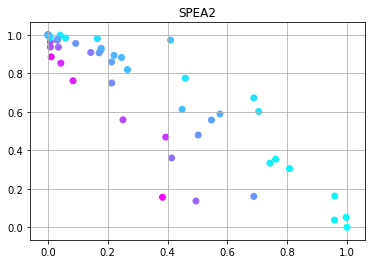

In [29]:
#Genetic Algorithm variables
population_size = 50
generations = 30
p_crossover = 0.9
p_mutation = 0.02
p_sample = 0.08

#Model variables
max_initial_depth = 3
dimensions = len(X_normalised_features[0])

Model = SymbollicTreeFunction(
    generate_terminal,
    evaluate_fitness_f = evaluate_fitness_SPEA2,
    max_initial_depth = max_initial_depth,
    )

#testing
population = [IndividualClass(Model._generate_individual()) for _ in range(population_size)]
print(dimensions)
print(population[0].fenotype)
print(evaluate_tree_image(0, population[0].fenotype))
individuals_fitness = Model.evaluate([individual.fenotype for individual in population])


generation: 0


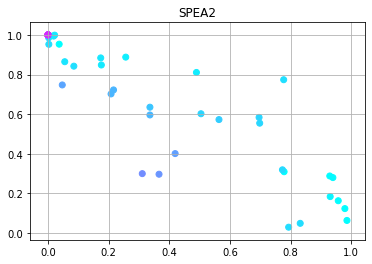

darwin_champion: (safe_divide (safe_divide (sub 16 9) (add 0 3)) (mul (safe_divide 1 12) (safe_divide 0.06697047063960737 12)))
darwin_champion's evaluation: 1
generation: 1


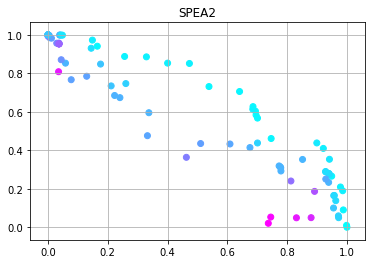

darwin_champion: (sub (add (mul 4 7) (sub 3 7)) (add (sub 9 0) (mul 14 11)))
darwin_champion's evaluation: 0


ZeroDivisionError: division by zero

In [34]:
ga = GeneticAlgorithm(population_size, generations, p_crossover, p_mutation, p_sample)
dc,cs = ga.fit(Model)

#Results
print("Darwin champion:", dc)
print("Darwin champion score:", cs)